# Zestaw 8. Dekompozycja spektralna

In [152]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from random import randint

## 1. Metoda potęgowa

<i>Napisz funkcję obliczającą metodą potęgową dominującą wartość własną (największą co do modułu) i odpowiadający jej wektor własny dla danej macierzy rzeczywistej symetrycznej. Sprawdź automatycznie poprawność działania programu porównując wyniki(dominująca wartość własna i odpowiadający jej wektor własny) własnej implementacji z funkcją biblioteczną.</i>

In [2]:
def power_iteration(A, epsilon=1e-8, max_iteration=100):
    n = A.shape[0]
    prev_x = np.ones(n)
    x = A @ prev_x
    
    max_x = np.linalg.norm(x)
    x = x/max_x
    iteration = 1
    
    while iteration < max_iteration and np.linalg.norm(x - prev_x) > epsilon:
        x, prev_x = A @ x, x
        max_x = np.linalg.norm(x)
        x = x/max_x
        iteration += 1
        
    return max_x, x, iteration

In [40]:
A = np.random.rand(4, 4)
A = A + A.T

In [41]:
eigenvalue, eigenvector, _ = power_iteration(A)
np_eigenvalue, np_eigenvector = max(np.linalg.eig(A)[0]), np.linalg.eig(A)[1][:, 0]

print(eigenvalue)
print(np_eigenvalue, '\n')

print(eigenvector)
print(np_eigenvector, '\n')

print("correct?", 
     np.isclose(eigenvalue, np_eigenvalue) and
    (np.allclose(eigenvector, np_eigenvector)
     or np.allclose(eigenvector, -np_eigenvector)))

4.01320817556498
4.013208175564981 

[0.57696035 0.41719733 0.51806353 0.47399717]
[0.57696035 0.41719733 0.51806353 0.47399717] 

correct? True


<i>Przedstaw na wykresie zależność czasu obliczeń obu implementacji od rozmiaru macierzy (rozmiary macierzy NxN gdzie N = range(100, 2500, 100)). Opisz i zinterpretuj wyniki.</i>

In [53]:
def plot_times():
    ns = list(range(100, 2500, 500))
    power_times = []
    np_times = []
    
    for n in ns:
        A = np.random.rand(n, n)
        A = A + A.T
        
        start = time()
        power_iteration(A)
        end = time()
        power_times.append(end-start)
        
        start = time()
        np.linalg.eig(A)
        end = time()
        np_times.append(end-start)
    
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.set_xlabel('n - matrix size [1]')
    ax.set_ylabel('t - time[s]')
    
    ax.plot(ns, power_times, marker='o', linewidth=3, color='yellow', label='power iteration method')
    ax.plot(ns, np_times, marker='o', linewidth=3, color='cornflowerblue', label='np.linalg.eig')
    
    plt.legend()
    plt.show()

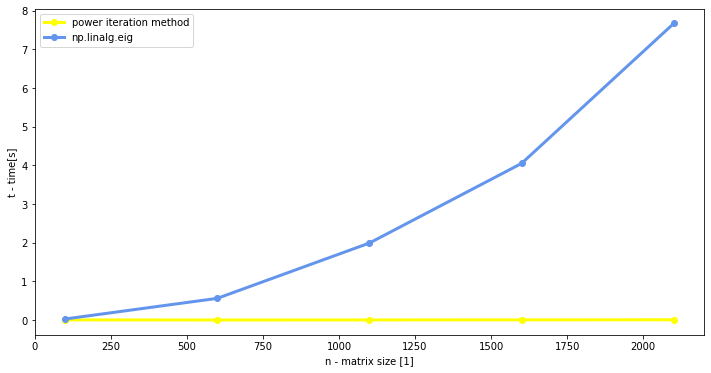

In [54]:
plot_times()

Zaimplementowana metoda potęgowa znajduje dominującą wartość i wektor własny dużo szybciej niż funkcja biblioteczna. Wynika to w głównie z faktu, iż funkcja z biblioteki numpy zwraca wszystkie wartości i wektory własne, a wyżej zaimplementowana funkcja tylko jedną wartość i związany z nią wektor.

## 2. Odwrotna metoda potęgowa

<i>Opierając się na twierdzeniu o transformacji widma macierzy oraz wykorzystując metodę potęgową i faktoryzację LU zaimplementuj odwrotną metodę potęgową pozwalającą na szybkie znalezienie wektorów własnych macierzy A, dla wartości σ bliskich odpowiedniej wartości własnej. Wykorzystaj fakt, że mnożenie wektora $x_i$ przez macierz $A^{−1}$ odpowiada rozwiązaniu układu równań $Ax_{i+1} = x_i$.

Opisz poszczególne kroki algorytmu i zinterpretuj wyniki. </i>

In [59]:
def lu_factorization(A):
    n = A.shape[0]
    A = A.copy()
    U = A.copy()
    L = np.zeros((n, n))
    I = np.eye(n)
    
    scales = [max(A[i,:], key=lambda x: abs(x)) for i in range(n)]
    
    for i in range(n):
        max_a = 0
        p = -1
        
        for row in range(i, n):
            if abs(U[row, i]/scales[row]) > max_a:
                max_a = abs(U[row, i])/scales[row]
                p = row
                
        if p == -1:
            return
        
        A[[p, i]] = A[[i, p]]
        U[[p, i]] = U[[i, p]]
        L[[p, i]] = L[[i, p]]
        I[[p, i]] = I[[i, p]]
        L[i, i] = 1
        
        for j in range(i+1, n):
            a = U[j, i]
            U[j,:] -= (U[j, i]/U[i, i])* U[i, :]
            L[j, i] = a/U[i, i]
    
    return L, U, A, I

def lu_solve(A, B):
    n = A.shape[0]
    L, U, A, I = lu_factorization(A)
    B = I @ B
    
    y = np.zeros(n)
    for i in range(n):
        y[i] = (B[i] - np.sum(L[i, :i]*y[:i]))
    
    x = np.zeros(n)
    for i in range(n-1, -1, -1):
        x[i] = (y[i] - np.sum(U[i, i+1:]*x[i+1:]))/U[i, i]
        
    return x

In [179]:
def inverse_power(A, sigma, epsilon=1e-4, max_iteration=100):
    n = A.shape[0]
    A = A - sigma*np.eye(n)
    
    prev_x = np.ones(n)
    x = A @ prev_x
    
    max_x = np.linalg.norm(x)
    x = x/max_x
    iteration = 1
    
    while iteration < max_iteration and np.linalg.norm(x - prev_x) > epsilon and not np.allclose(x, -prev_x):
        x, prev_x = lu_solve(A, x), x
        max_x = np.linalg.norm(x)
        x = x/max_x
        
        iteration += 1
        
    return 1/(max_x) + sigma, x, iteration

In [180]:
sigma = 3
print(*inverse_power(A, sigma))

eig_values, eig_vectors = np.linalg.eig(A)

closest = min(range(len(eig_vectors)), key=lambda i: abs(eig_values[i] - sigma))

print(eig_values[closest], eig_vectors[:, closest])
print()

for i in range(len(eig_values)):
    print(eig_values[i], eig_vectors[:, i])

4.013208176974812 [0.57697258 0.41718647 0.51807101 0.47398367] 11
4.013208175564981 [0.57696035 0.41719733 0.51806353 0.47399717]

4.013208175564981 [0.57696035 0.41719733 0.51806353 0.47399717]
-1.1912218567499024 [ 0.60929437 -0.03428659 -0.77962034  0.14063048]
0.4167527361710363 [-0.54291722  0.45334334 -0.33162976  0.62429353]
-0.42760492554738005 [-0.03343676 -0.7869248   0.11757553  0.60482009]


kroki algorytmu:

interpretacja wyników:

## 3. Iteracje z ilorazem Rayleigha

<i> Zaimplementuj iteracyjną metodę wyznaczania wartości własnej i skojarzonego z nią wektora własnego wykorzystując odwróconą metodę potęgową oraz iloraz Rayleigha. Porównaj zbieżność metody ze zbieżnością algorytmu potęgowego (macierz symetryczna rzeczywista). Opisz poszczególne kroki algorytmu i zinterpretuj wyniki. </i>

In [181]:
def inverse_rayleigh(A, sigma, epsilon=1e-4, max_iteration=100):
    n = A.shape[0]
    M = A - sigma*np.eye(n)
    
    prev_x = np.ones(n)
    x = A @ prev_x
    
    max_x = np.linalg.norm(x)
    x = x/max_x
    iteration = 1
    
    while iteration < max_iteration and np.linalg.norm(x - prev_x) > epsilon and not np.allclose(x, -prev_x):
        sigma = (x@A@x.T)/(x@x.T)
        M = A - sigma*np.eye(n)
        
        x, prev_x = lu_solve(M, x), x
        max_x = np.linalg.norm(x)
        x = x/max_x
        
        iteration += 1
        
    return 1/(max_x) + sigma, x, iteration

In [182]:
sigma = 3
print(*inverse_rayleigh(A, sigma))

eig_values, eig_vectors = np.linalg.eig(A)

closest = min(range(len(eig_vectors)), key=lambda i: abs(eig_values[i] - sigma))

print(eig_values[closest], eig_vectors[:, closest])
print()

for i in range(len(eig_values)):
    print(eig_values[i], eig_vectors[:, i])

4.013208175564978 [0.57696035 0.41719733 0.51806353 0.47399717] 3
4.013208175564981 [0.57696035 0.41719733 0.51806353 0.47399717]

4.013208175564981 [0.57696035 0.41719733 0.51806353 0.47399717]
-1.1912218567499024 [ 0.60929437 -0.03428659 -0.77962034  0.14063048]
0.4167527361710363 [-0.54291722  0.45334334 -0.33162976  0.62429353]
-0.42760492554738005 [-0.03343676 -0.7869248   0.11757553  0.60482009]


In [183]:
def compare_convergence():
    ns = list(range(5, 100, 10))
    inverse_times = []
    rayleigh_times = []
    
    inverse_iterations = []
    rayleigh_iterations = []
    
    for n in ns:
        A = np.random.rand(n, n)
        A = A + A.T
        sigma = 0
        
        start = time()
        _, _, iterations = inverse_power(A, sigma)
        end = time()
        inverse_iterations.append(iterations)
        inverse_times.append(end - start)
        
        start = time()
        _, _, iterations = inverse_rayleigh(A, sigma)
        end = time()
        rayleigh_iterations.append(iterations)
        rayleigh_times.append(end - start)
        
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    ax[0].set_xlabel('n - matrix size [1]')
    ax[0].set_ylabel('i - iterations needed [1]')
    
    ax[1].set_xlabel('n - matrix size [1]')
    ax[1].set_ylabel('t - time [s]')
    
    ax[0].plot(ns, inverse_iterations, label='inverse power method', marker='o', linewidth=3, color='sandybrown')
    ax[0].plot(ns, rayleigh_iterations, label='inverse power method with Rayleigh quotient', marker='o', linewidth=3, color='rosybrown')
    
    
    ax[1].plot(ns, inverse_times, label='inverse power method', marker='o', linewidth=3, color='sandybrown')
    ax[1].plot(ns, rayleigh_times, label='inverse power method with Rayleigh quotient', marker='o', linewidth=3, color='rosybrown')
    
    plt.legend()
    plt.show()
        

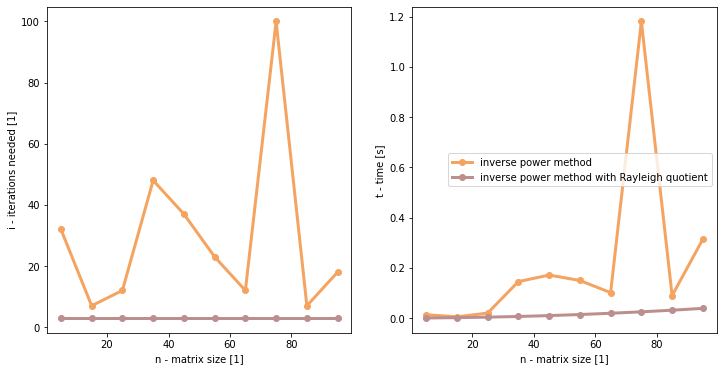

In [184]:
compare_convergence()

kroki algorytmu:

wyniki: Dzięki użyciu ilorazu Rayleigha procedura zbiega dużo szybciej.

## Wnioski

- Jesteśmy w stanie w stosunkowo szybki sposób znajdować przybliżenia wartości i wektorów własnych, w szczególności jeśli interesuje nas tylko największa wartość, lub najbliższa danej liczby.
- Dekompozycja spektralna przydaja się w wielu zagadnieniach matematycznych.

M. Hawryluk 09.05.2021